# Finally, some open source soccer data
This blog was created with the intention of someday using player position data to analyze player performance. For a long time this data was unavailable unless you were willing to pay a ton to a private company like [Opta][2], but in stepped Statsbomb. I already deeply admired Statsbomb work, then earlier this year they began producing [their own data][3] sources for game analysis. Fortunately, they also decided to release a subset of this data, setting up a [github repo][1] for all to access. Interestingly, it's also data from the [women's game][4] where there is less public analysis of player performance. I've decided to try and analyze some of this data and it starts with properly loading in the data which is what this post is about. To be clear, I'm doing this as practice for writing functions in python given that Statsbomb already [offers similar functions][5] in R and I'll be loading the data using their library to see the end product of their cleaning as a benchmark for mine.
[1]: https://github.com/statsbomb/open-data/tree/master/data
[2]: https://www.optasports.com/services/data-feeds/
[3]: https://statsbomb.com/2018/05/statsbomb-data-launch-beyond-naive-xg/
[4]: https://statsbomb.com/2018/06/statsbomb-announces-free-data-for-womens-football/
[5]: https://github.com/statsbomb/StatsBombR

In [1]:
%matplotlib inline

# Imported packages
import pandas as pd
import numpy as np
import json
import re
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

# Display options 
pd.options.display.max_columns = None
from IPython.display import display

# Data structure
Statsbomb's data covers three different types of events: events - the actual events in a given match; lineups - ; and matches - descriptions of the competitions where the matches come from. All of the data is stored in JSON files and there are detailed descriptions of the JSON in the repo to understand the JSON. Initially, I was writing custom read functions to deal with the nested lists and dictionaries in the data, but then found [this post][5] on the JSON normalize function which takes care of a lot of the work for me. The function below loads various statsbomb data: events, matches, and lineups. I've also included a way to load the 'shots' data. This load feature isolates shots from the event data, restructures the 'shot_freeze_frame' column into a long form dataframe, and brings in goal keeper data related to each shot.

I need to determine a way to load all the json data at once with this cleaning process and not just one json file at a time.
[5]:https://stackoverflow.com/questions/43656970/json-to-python-dataframe

In [2]:
def read_statsbomb(filename, filetype="events"):
    '''Function to read in open source JSON data from Statsbomb'''
    
    # Checking for valid JSON format
    valid_filetype = {'events', 'matches', 'lineups', 'shots'}
    try: 
        filetype in valid_filetype == True
    except ValueError:
        print("results: filetype must be one of %r." % valid_filetype)

        
    # Reading in data
    data = open(filename).read()
    js = json.loads(str(data))
    
    # Processing data into appropriate dataframes
    if filetype == 'events':
        # loading in the data
        df = json_normalize(js)
        
        # Renaming columns 
        df = df.rename(columns=lambda x: re.sub('\.','_',x))
        
        # breaking apart the location columns
        df[['location_x', 'location_y']] = df['location'].apply(pd.Series)
        df[['pass_end_location_x', 'pass_end_location_y']] = df['pass_end_location'].apply(pd.Series)
        df[['shot_end_location_x', 'shot_end_location_y', 'shot.end_location_z']] = df['shot_end_location'].apply(pd.Series)
        
        df_result = df
        
    elif filetype == 'lineups':
        df_result = json_normalize(js)
        
    elif filetype == 'shots':
        df = json_normalize(js)
        
        # Renaming columns 
        df = df.rename(columns=lambda x: re.sub('\.','_',x))
        
        # Selecting shots and related columns
        ###################################################
        # Add in gk columns
        df = df[df['type_name'] == 'Shot']
        shot_cols = ['id', 'shot_outcome_id', 'shot_outcome_name', 'index', 'location', 'minute', 
                     'player_id', 'player_name', 'position_id', 'position_name', u'possession',
                     'possession_team_id', 'possession_team_name', u'period',
                     'play_pattern_id', 'play_pattern_name', 'team_id', 'team_name', 'timestamp', 
                     'type_id', 'type_name', 'under_pressure', 'shot_type_name', 'period', 'duration',
                     'shot_type_id', 'shot_statsbomb_xg', 'shot_freeze_frame', 'shot_key_pass_id',
                     'shot_end_location', 'shot_body_part_id', 'shot_body_part_name', 'shot_one_on_one', 
                     'shot_first_time', 'shot_follows_dribble', 'shot_technique_id', 'shot_technique_name',
                      ]
        df = pd.DataFrame(df, columns=shot_cols)
        
        # breaking apart the location columns
        df[['shot_start_location_x', 'shot_start_location_y']] = df['location'].apply(pd.Series)
        df[['shot_end_location_x', 'shot_end_location_y', 'shot_end_location_z']] = df['shot_end_location'].apply(pd.Series)
        
        # renaming some columns so they don't get confused with later columns
        df = df.rename(index=str, columns={"location": "shot_start_location", "player_id": "shot_player_id",
                                          'player_name': 'shot_player_name', 'position_id': 'shot_position_id',
                                          'position_name': 'shot_position_name'})
        
        df_shot = pd.DataFrame()
        for shot in range(0,len(df)):
            # Pulling out the shot freeze frame column into it's own dataframe
            df_shot_freeze_frame = json_normalize(df.shot_freeze_frame.iloc[shot])
            df_shot_freeze_frame = df_shot_freeze_frame.rename(index=str, columns={"location": "other_player_location", "player.id": "other_player_id",
                                          'player.name': 'other_player_name', 'position.id': 'other_position_id',
                                          'position.name': 'other_position_name'})
            df_shot_freeze_frame[['other_player_location_x', 'other_player_location_y']] = df_shot_freeze_frame['other_player_location'].apply(pd.Series)

            # Setting up the row the shot freeze frame came from as a long dataframe 
            df_orig = df.iloc[shot].to_frame().T.reset_index()
    
            # joining the shot freeze frame dataframe to the original dataframe
            result = pd.concat([df_shot_freeze_frame, df_orig], axis=1).fillna(method='ffill')
            result = result.drop(result.index[0])
    
            # Appending to final dataframe
            df_shot = df_shot.append(result)
            df_shot = df_shot.reset_index(drop=True)

        df_result = df_shot.rename(index=str, columns={'level_0':'prev_index'})
    
    # Reshaping and appending data from goal keeper actions related to the shots

    else:
        df_result = json_normalize(js)
    
    return(df_result)


# Loading test event data to figure out how to properly load in the shot data

In [3]:
test_df = read_statsbomb('data/events/7298.json')

In [4]:
events_file = 'data/events/7298.json'
data_events = open('data/events/7298.json').read()
try: js_events = json.loads(str(data_events))
except: js_events = None

In [5]:
df_events = json_normalize(js_events)

In [6]:
df_events = df_events.rename(columns=lambda x: re.sub('\.','_',x))
df_events = df_events.rename(columns=lambda x: re.sub("u'",'',x))

In [ ]:
list(df_events)

In [7]:
## Figuring out the shot dataframe load. The shot freeze frame column is it's own dataframe, 
## thus each cell needs to be expanded into their own dataframe and then concatenating the 
## original data back to it 
# Selecting shots and related columns
df = df_events[df_events['type_name'] == 'Shot']
shot_cols = ['id', 'shot_outcome_id', 'shot_outcome_name', 'index', 'location', 'minute', 
            'player_id', 'player_name', 'position_id', 'position_name', u'possession',
            'possession_team_id', 'possession_team_name', u'period',
            'play_pattern_id', 'play_pattern_name', 'team_id', 'team_name', 'timestamp', 
            'type_id', 'type_name', 'under_pressure', 'shot_type_name', 'period', 'duration',
            'shot_type_id', 'shot_statsbomb_xg', 'shot_freeze_frame', 'shot_key_pass_id',
            'shot_end_location', 'shot_body_part_id', 'shot_body_part_name', 'shot_one_on_one', 
            'shot_first_time', 'shot_follows_dribble', 'shot_technique_id', 
             'shot_technique_name'
            ]
df = pd.DataFrame(df, columns=shot_cols)
        
# breaking apart the location columns
df[['shot_start_location_x', 'shot_start_location_y']] = df['location'].apply(pd.Series)
df[['shot_end_location_x', 'shot_end_location_y', 'shot_end_location_z']] = df['shot_end_location'].apply(pd.Series)
        
# renaming some columns so they don't get confused with later columns
df = df.rename(index=str, columns={"location": "shot_start_location", "player_id": "shot_player_id",
                                    'player_name': 'shot_player_name', 'position_id': 'shot_position_id',
                                    'position_name': 'shot_position_name'})

df_shot = pd.DataFrame()
for shot in range(0,len(df)):
    # Pulling out the shot freeze frame column into it's own dataframe
    df_shot_freeze_frame = json_normalize(df.shot_freeze_frame.iloc[shot])
    df_shot_freeze_frame = df_shot_freeze_frame.rename(index=str, columns={"location": "other_player_location", "player.id": "other_player_id",
                                          'player.name': 'other_player_name', 'position.id': 'other_position_id',
                                          'position.name': 'other_position_name'})
    df_shot_freeze_frame[['other_player_location_x', 'other_player_location_y']] = df_shot_freeze_frame['other_player_location'].apply(pd.Series)

    # Setting up the row the shot freeze frame came from as a long dataframe 
    df_orig = df.iloc[shot].to_frame().T.reset_index()
    
    # joining the shot freeze frame dataframe to the original dataframe
    result = pd.concat([df_shot_freeze_frame, df_orig], axis=1).fillna(method='ffill')
    result = result.drop(result.index[0])
    
    # Appending to final dataframe
    df_shot = df_shot.append(result)
    df_shot = df_shot.reset_index(drop=True)

df_shot = df_shot.rename(index=str, columns={'level_0':'prev_index'})

df_shot.head()

,other_player_location,other_player_id,other_player_name,other_position_id,other_position_name,teammate,other_player_location_x,other_player_location_y,prev_index,id,shot_outcome_id,shot_outcome_name,index,shot_start_location,minute,shot_player_id,shot_player_name,shot_position_id,shot_position_name,possession,possession_team_id,possession_team_name,period,play_pattern_id,play_pattern_name,team_id,team_name,timestamp,type_id,type_name,under_pressure,shot_type_name,period,duration,shot_type_id,shot_statsbomb_xg,shot_freeze_frame,shot_key_pass_id,shot_end_location,shot_body_part_id,shot_body_part_name,shot_one_on_one,shot_first_time,shot_follows_dribble,shot_technique_id,shot_technique_name,shot_start_location_x,shot_start_location_y,shot_end_location_x,shot_end_location_y,shot_end_location_z
0,"[113.0, 32.0]",4658.0,Keira Walsh,14.0,Center Midfield,False,113.0,32.0,33,61149bb7-bd43-4260-a0f9-7e058eaad3ce,96.0,Blocked,34,"[115.0, 25.0]",0,4641.0,Francesca Kirby,22.0,Right Center Forward,4,971,Chelsea LFC,1,1,Regular Play,971,Chelsea LFC,00:00:47.620,16,Shot,NaN,Open Play,1,0.56,87.0,0.123623,"[{u'player': {u'id': 4658, u'name': u'Keira Wa...",95ffe924-77f3-40e2-afc6-23e5fed8865f,"[117.0, 34.0]",40.0,Right Foot,NaN,NaN,1.0,93.0,Normal,115.0,25.0,117.0,34.0,NaN
1,"[115.0, 41.0]",4651.0,Demi Stokes,6.0,Left Back,False,115.0,41.0,33,61149bb7-bd43-4260-a0f9-7e058eaad3ce,96.0,Blocked,34,"[115.0, 25.0]",0,4641.0,Francesca Kirby,22.0,Right Center Forward,4,971,Chelsea LFC,1,1,Regular Play,971,Chelsea LFC,00:00:47.620,16,Shot,NaN,Open Play,1,0.56,87.0,0.123623,"[{u'player': {u'id': 4658, u'name': u'Keira Wa...",95ffe924-77f3-40e2-afc6-23e5fed8865f,"[117.0, 34.0]",40.0,Right Foot,NaN,NaN,1.0,93.0,Normal,115.0,25.0,117.0,34.0,NaN
2,"[115.0, 36.0]",4655.0,Jennifer Beattie,5.0,Left Center Back,False,115.0,36.0,33,61149bb7-bd43-4260-a0f9-7e058eaad3ce,96.0,Blocked,34,"[115.0, 25.0]",0,4641.0,Francesca Kirby,22.0,Right Center Forward,4,971,Chelsea LFC,1,1,Regular Play,971,Chelsea LFC,00:00:47.620,16,Shot,NaN,Open Play,1,0.56,87.0,0.123623,"[{u'player': {u'id': 4658, u'name': u'Keira Wa...",95ffe924-77f3-40e2-afc6-23e5fed8865f,"[117.0, 34.0]",40.0,Right Foot,NaN,NaN,1.0,93.0,Normal,115.0,25.0,117.0,34.0,NaN
3,"[117.0, 31.0]",4648.0,Abbie McManus,3.0,Right Center Back,False,117.0,31.0,33,61149bb7-bd43-4260-a0f9-7e058eaad3ce,96.0,Blocked,34,"[115.0, 25.0]",0,4641.0,Francesca Kirby,22.0,Right Center Forward,4,971,Chelsea LFC,1,1,Regular Play,971,Chelsea LFC,00:00:47.620,16,Shot,NaN,Open Play,1,0.56,87.0,0.123623,"[{u'player': {u'id': 4658, u'name': u'Keira Wa...",95ffe924-77f3-40e2-afc6-23e5fed8865f,"[117.0, 34.0]",40.0,Right Foot,NaN,NaN,1.0,93.0,Normal,115.0,25.0,117.0,34.0,NaN
4,"[109.0, 39.0]",4645.0,Isobel Christiansen,15.0,Left Center Midfield,False,109.0,39.0,33,61149bb7-bd43-4260-a0f9-7e058eaad3ce,96.0,Blocked,34,"[115.0, 25.0]",0,4641.0,Francesca Kirby,22.0,Right Center Forward,4,971,Chelsea LFC,1,1,Regular Play,971,Chelsea LFC,00:00:47.620,16,Shot,NaN,Open Play,1,0.56,87.0,0.123623,"[{u'player': {u'id': 4658, u'name': u'Keira Wa...",95ffe924-77f3-40e2-afc6-23e5fed8865f,"[117.0, 34.0]",40.0,Right Foot,NaN,NaN,1.0,93.0,Normal,115.0,25.0,117.0,34.0,NaN


In [ ]:
## Need to add the goal keeper information per shot to the shot dataframe
df_gk = df_events[df_events['type_name'] == 'Goal Keeper']


# other functions to transform the shot data
Statsbomb provides functions to 'clean' shot data in R. This cleaning adds columns, mostly related to the shot data, for important features such as the distance from goal, the angle to goal, and the number of defenders between the shooter and the goal. The functions below create similar features in python.

In [ ]:
def dist_to_goal():


def dist_to_gk():

    
def angle_to_goal():
    
def angle_to_gk():

def ave_velocity():
    
def def_density():
    
def dist_def_1():
    
def dist_def_2():
    
def att_behind_ball():
    
def def_behind_ball():
    
def def_in_cone():

def att_in_cone():

def gk_in_cone():

def density_in_cone():
    
def def_area():
    
def def_cone_area():

def clean_shots():


# Function to draw pitch
While [others][1] have already created functions to draw soccer pitches, I decided to create my own function to (1) practice drawing/graphing in python and (2) because the functions I found used different pitches sizes than what is found in [Statsbomb][2].
[1]: https://fcpython.com/visualisation/drawing-pass-map-python
[2]: https://github.com/statsbomb/open-data/blob/master/doc/StatsBomb%20Event%20Data%20Specification%20v1.0.2.pdf

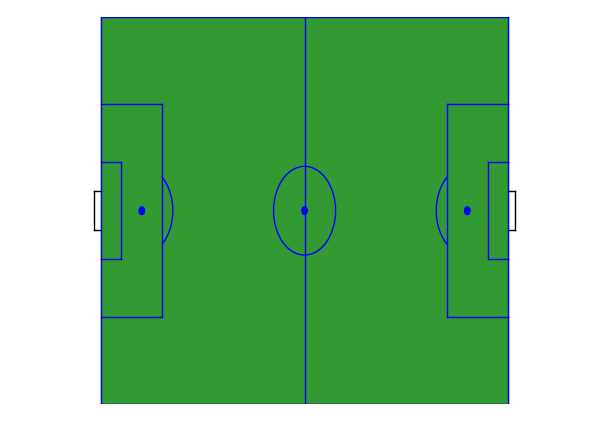

In [12]:
def draw_pitch(orientation="horizontal", pitch_color='white', pitch_lines='black', pitch_alpha=0.8):
    '''Function that draws a soccer pitch with various specifications'''

    
    # Checking for valid JSON format
    valid_orientation = {'horizontal', 'vertical'}
    try: 
        orientation in valid_orientation == True
    except ValueError:
        print("results: orientation must be one of %r." % valid_orientation)
    
    # Pitch Outline & Centre Line
    if orientation=='vertical':
        # create figure
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        fig.set_size_inches(5, 7)

        # pitch dimensions and fill
        x = [0,0,80,80]
        y = [0,120,120,0]
        ax.fill(x,y, color=pitch_color, alpha=pitch_alpha)

        # Draw pitch
        plt.plot([0,0],[0,120], color=pitch_lines) # left line
        plt.plot([80,80],[0,120], color=pitch_lines) # right line
        plt.plot([0,80],[120,120], color=pitch_lines) # top endline
        plt.plot([0,80],[0,0], color=pitch_lines) # bottom endline
        plt.plot([0,80],[60,60], color=pitch_lines) # half line

        #top Penalty Area
        plt.plot([18,18],[120,102],color=pitch_lines)
        plt.plot([62,62],[120,102],color=pitch_lines)
        plt.plot([18,62],[102,102],color=pitch_lines)

        #bottom Penalty Area
        plt.plot([18,18],[0,18],color=pitch_lines)
        plt.plot([62,62],[0,18],color=pitch_lines)
        plt.plot([18,62],[18,18],color=pitch_lines)

        #bottom 6-yard Box
        plt.plot([30,30],[0,6],color=pitch_lines)
        plt.plot([50,50],[0,6],color=pitch_lines)
        plt.plot([30,50],[6,6],color=pitch_lines)

        #bottom 6-yard Box
        plt.plot([30,30],[120,114],color=pitch_lines)
        plt.plot([50,50],[120,114],color=pitch_lines)
        plt.plot([30,50],[114,114],color=pitch_lines)

        #Prepare top goal
        plt.plot([36,36],[120,122],color='black')
        plt.plot([44,44],[120,122],color='black')
        plt.plot([36,44],[122,122],color='black')
        
        #Prepare bottom goal
        plt.plot([36,36],[0,-2],color='black')
        plt.plot([44,44],[0,-2],color='black')
        plt.plot([36,44],[-2,-2],color='black')
        
        #Prepare Circles
        centreCircle = plt.Circle((40,60),9.15,color=pitch_lines,fill=False)
        centreSpot = plt.Circle((40,60),0.8,color=pitch_lines)
        bottomPenSpot = plt.Circle((40,12),0.8,color=pitch_lines)
        topPenSpot = plt.Circle((40,108),0.8,color=pitch_lines)

        #Draw Circles
        ax.add_patch(centreCircle)
        ax.add_patch(centreSpot)
        ax.add_patch(bottomPenSpot)
        ax.add_patch(topPenSpot)

        # #Prepare Arcs
        topArc = Arc((40,12),height=18.3,width=18.3,angle=0,theta1=40,theta2=140,color=pitch_lines)
        bottomArc = Arc((40,108),height=18.3,width=18.3,angle=0,theta1=220,theta2=320,color=pitch_lines)

        # #Draw Arcs
        ax.add_patch(topArc)
        ax.add_patch(bottomArc)

        #Tidy Axes
        plt.axis('off')

    else:
        # create figure
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        fig.set_size_inches(7, 5)

        # pitch dimensions and fill
        x = [0,0,120,120]
        y = [0,80,80,0]
        ax.fill(x,y, color=pitch_color, alpha=.8)

        # Draw pitch
        plt.plot([0,0],[0,80], color=pitch_lines) # bottom line
        plt.plot([0,120],[80,80], color=pitch_lines) # Top line
        plt.plot([120,120],[80,0], color=pitch_lines) # Right endline
        plt.plot([120,0],[0,0], color=pitch_lines) # left endline
        plt.plot([60,60],[0,80], color=pitch_lines) # half line

        #Left Penalty Area
        plt.plot([0,18],[62,62],color=pitch_lines)
        plt.plot([0,18],[18,18],color=pitch_lines)
        plt.plot([18,18],[18,62],color=pitch_lines)

        #Right Penalty Area
        plt.plot([120,102],[62,62],color=pitch_lines)
        plt.plot([102,102],[18,62],color=pitch_lines)
        plt.plot([120,102],[18,18],color=pitch_lines)

        #Left 6-yard Box
        plt.plot([0,6],[30,30],color=pitch_lines)
        plt.plot([0,6],[50,50],color=pitch_lines)
        plt.plot([6,6],[30,50],color=pitch_lines)

        #Right 6-yard Box
        plt.plot([120,114],[30,30],color=pitch_lines)
        plt.plot([120,114],[50,50],color=pitch_lines)
        plt.plot([114,114],[30,50],color=pitch_lines)
    
        #Prepare right goal
        plt.plot([120,122],[36,36],color='black')
        plt.plot([120,122],[44,44],color='black')
        plt.plot([122,122],[44,36],color='black')
        
        #Prepare left goal
        plt.plot([0,-2],[36,36],color='black')
        plt.plot([0,-2],[44,44],color='black')
        plt.plot([-2,-2],[44,36],color='black')
        
        #Prepare Circles
        centreCircle = plt.Circle((60,40),9.15,color=pitch_lines,fill=False)
        centreSpot = plt.Circle((60,40),0.8,color=pitch_lines)
        leftPenSpot = plt.Circle((12,40),0.8,color=pitch_lines)
        rightPenSpot = plt.Circle((108,40),0.8,color=pitch_lines)
        
        #Draw Circles
        ax.add_patch(centreCircle)
        ax.add_patch(centreSpot)
        ax.add_patch(leftPenSpot)
        ax.add_patch(rightPenSpot)

        #Prepare Arcs
        leftArc = Arc((12,40),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,
                      color=pitch_lines)
        rightArc = Arc((108,40),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,
                       color=pitch_lines)

        #Draw Arcs
        ax.add_patch(leftArc)
        ax.add_patch(rightArc)

        #Tidy Axes
        plt.axis('off')

    return(plt.show())

draw_pitch(orientation='horizontal', pitch_lines='blue', pitch_color='green')